<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_Normal_OHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[4] #Normal with OHE
test_file = file_path+file[5]
dataset= "Normal with OHE"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 445), (11403, 445), (75818, 445))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.814
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 9.33 s, sys: 1.15 s, total: 10.5 s
Wall time: 4min 18s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1 penalty='l2',
                  solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Normal with OHE dataset 		 



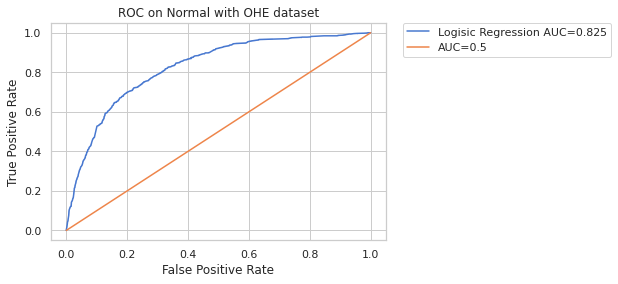

The log loss and auc was found to be 0.519 and 0.825 for Logisic Regression on Normal with OHE dataset.


In [9]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [10]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.790
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 7, 'max_leaf_nodes': 5000, 'max_depth': 10}
CPU times: user 5.61 s, sys: 226 ms, total: 5.83 s
Wall time: 4min 18s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                      splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=5000,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features=None,
                                                             max_leaf_nodes=5000,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=5,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
           

		 Decision Tree Classifier on Normal with OHE dataset 		 



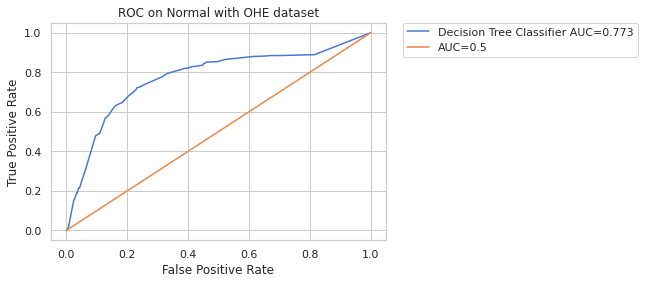

The log loss and auc was found to be 0.149 and 0.773 for Decision Tree Classifier on Normal with OHE dataset.


In [13]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [14]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5,7],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 68.3min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 3min 26s, sys: 308 ms, total: 3min 26s
Wall time: 1h 11min 47s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 5min 14s, sys: 1.23 s, total: 5min 15s
Wall time: 2min 40s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier on Normal with OHE dataset 		 



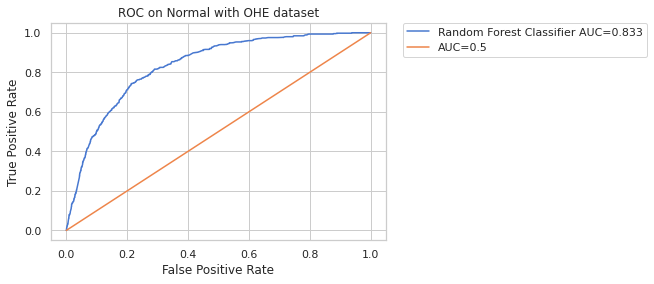

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier on Normal with OHE dataset.


In [17]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [18]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413


# Selecting top features

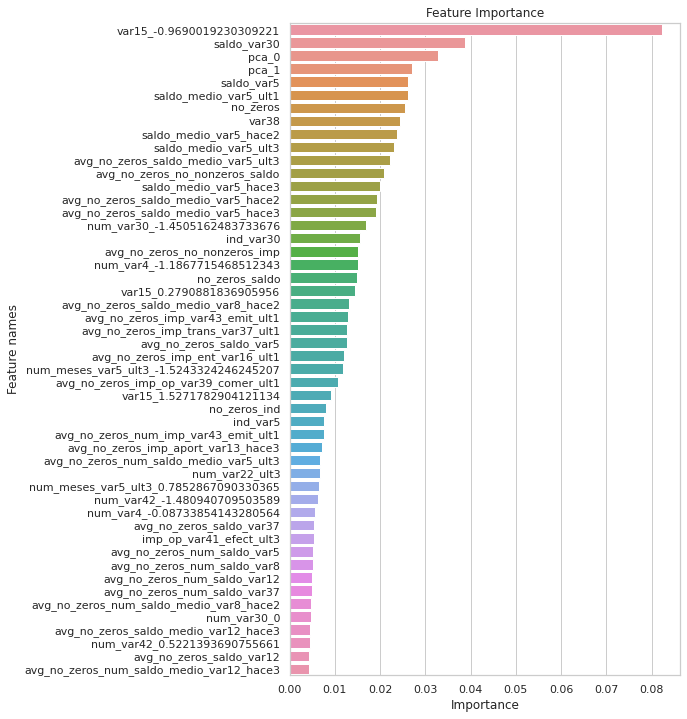

In [19]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [20]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_val[features].copy()

There are 28 features that have feature importance value above 0.01000


In [21]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_val[features].copy()

Taking top 100 features


In [22]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_val[features].copy()

Taking top 250 features


# XGB Classifier

In [23]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=0
                     )

In [24]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.798922	validation_0-error:0.039726
[1]	validation_0-auc:0.811593	validation_0-error:0.039551
[2]	validation_0-auc:0.818711	validation_0-error:0.039551
[3]	validation_0-auc:0.819372	validation_0-error:0.039551
[4]	validation_0-auc:0.821857	validation_0-error:0.039551
[5]	validation_0-auc:0.825028	validation_0-error:0.039551
[6]	validation_0-auc:0.823758	validation_0-error:0.039551
[7]	validation_0-auc:0.823179	validation_0-error:0.039551
[8]	validation_0-auc:0.823581	validation_0-error:0.039551
[9]	validation_0-auc:0.824046	validation_0-error:0.039551
[10]	validation_0-auc:0.824375	validation_0-error:0.039551
[11]	validation_0-auc:0.823799	validation_0-error:0.039551
[12]	validation_0-auc:0.824317	validation_0-error:0.039551
[13]	validation_0-auc:0.82369	validation_0-error:0.039551
[14]	validation_0-auc:0.823254	validation_0-error:0.039551
[15]	validation_0-auc:0.823913	validation_0-error:0.039551
[16]	validation_0-auc:0.823583	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer on Normal with OHE dataset 		 



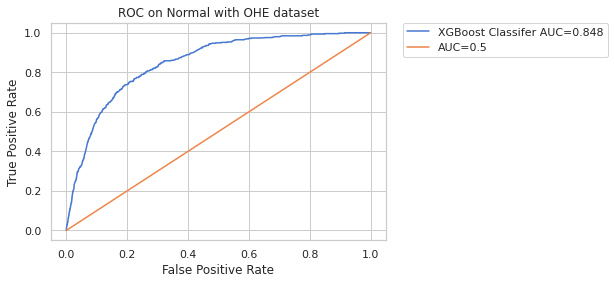

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer on Normal with OHE dataset.


In [25]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [26]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850


# LightGBM Classifier

In [54]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=348,
                      reg_alpha = 0.2,
                      max_depth=6, 
                      gamma=0
                     )


In [55]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165823	valid_0's auc: 0.784727
[2]	valid_0's binary_logloss: 0.165074	valid_0's auc: 0.818425
[3]	valid_0's binary_logloss: 0.164502	valid_0's auc: 0.811589
[4]	valid_0's binary_logloss: 0.163856	valid_0's auc: 0.819588
[5]	valid_0's binary_logloss: 0.163191	valid_0's auc: 0.825135
[6]	valid_0's binary_logloss: 0.162558	valid_0's auc: 0.829824
[7]	valid_0's binary_logloss: 0.162036	valid_0's auc: 0.82899
[8]	valid_0's binary_logloss: 0.16152	valid_0's auc: 0.828833
[9]	valid_0's binary_logloss: 0.160959	valid_0's auc: 0.829021
[10]	valid_0's binary_logloss: 0.16043	valid_0's auc: 0.831439
[11]	valid_0's binary_logloss: 0.159856	valid_0's auc: 0.833145
[12]	valid_0's binary_logloss: 0.159314	valid_0's auc: 0.834312
[13]	valid_0's binary_logloss: 0.158839	valid_0's auc: 0.834954
[14]	valid_0's binary_logloss: 0.158393	valid_0's auc: 0.835364
[15]	valid_0's binary_logloss: 0.157997	valid_0's auc: 0.835432
[16]	valid_0's binary_logloss: 0.157519	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.6,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=348, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.2, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Normal with OHE dataset 		 



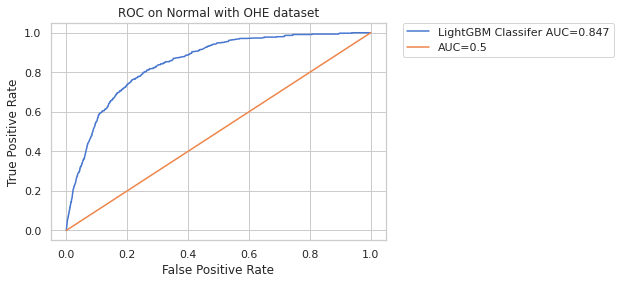

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer on Normal with OHE dataset.


In [56]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [57]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 37.7min finished


The best auc score was 0.821
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 1min 38s, sys: 343 ms, total: 1min 39s
Wall time: 39min 21s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [58]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [59]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (feature importance>0.01) on Normal with OHE dataset 		 



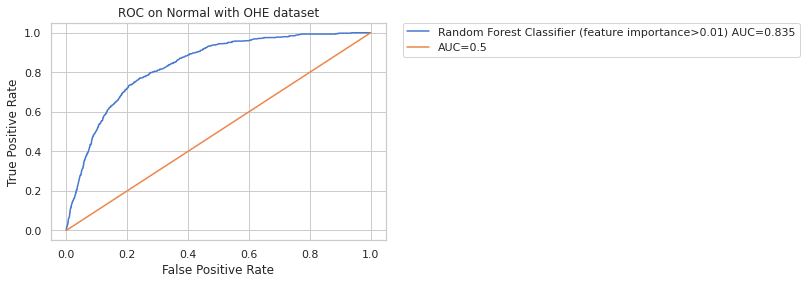

The log loss and auc was found to be 0.137 and 0.835 for Random Forest Classifier (feature importance>0.01) on Normal with OHE dataset.


In [60]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [61]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257


# XGB Classifier (feature importance>0.01)

In [98]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=1000,
                      reg_alpha = 0.3,
                      max_depth=5, 
                      gamma=5
                     )

In [99]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.815039	validation_0-error:0.039551
[1]	validation_0-auc:0.815978	validation_0-error:0.039551
[2]	validation_0-auc:0.817109	validation_0-error:0.039551
[3]	validation_0-auc:0.817562	validation_0-error:0.039551
[4]	validation_0-auc:0.817947	validation_0-error:0.039551
[5]	validation_0-auc:0.818651	validation_0-error:0.039551
[6]	validation_0-auc:0.81938	validation_0-error:0.039551
[7]	validation_0-auc:0.818578	validation_0-error:0.039551
[8]	validation_0-auc:0.819144	validation_0-error:0.039551
[9]	validation_0-auc:0.818155	validation_0-error:0.039551
[10]	validation_0-auc:0.818437	validation_0-error:0.039551
[11]	validation_0-auc:0.818786	validation_0-error:0.039551
[12]	validation_0-auc:0.818837	validation_0-error:0.039551
[13]	validation_0-auc:0.820487	validation_0-error:0.039551
[14]	validation_0-auc:0.818208	validation_0-error:0.039551
[15]	validation_0-auc:0.817838	validation_0-error:0.039551
[16]	validation_0-auc:0.817086	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=5,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Normal with OHE dataset 		 



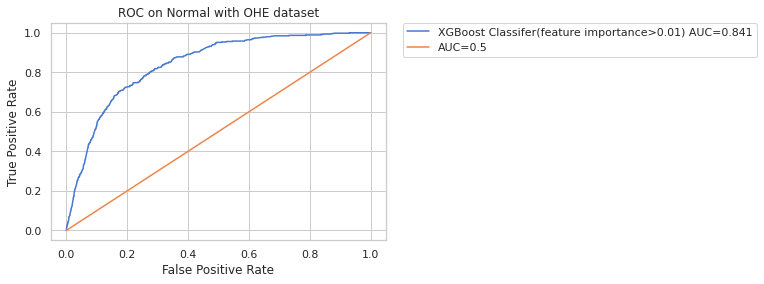

The log loss and auc was found to be 0.135 and 0.841 for XGBoost Classifer(feature importance>0.01) on Normal with OHE dataset.


In [100]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [101]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753


# LightGBM Classifier (feature importance>0.01)

In [126]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=605,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=0
                     )

In [127]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165889	valid_0's auc: 0.784715
[2]	valid_0's binary_logloss: 0.165257	valid_0's auc: 0.797503
[3]	valid_0's binary_logloss: 0.16455	valid_0's auc: 0.820265
[4]	valid_0's binary_logloss: 0.163968	valid_0's auc: 0.815247
[5]	valid_0's binary_logloss: 0.163347	valid_0's auc: 0.821359
[6]	valid_0's binary_logloss: 0.162743	valid_0's auc: 0.825541
[7]	valid_0's binary_logloss: 0.162246	valid_0's auc: 0.822664
[8]	valid_0's binary_logloss: 0.161738	valid_0's auc: 0.821997
[9]	valid_0's binary_logloss: 0.16115	valid_0's auc: 0.825562
[10]	valid_0's binary_logloss: 0.160614	valid_0's auc: 0.827806
[11]	valid_0's binary_logloss: 0.160116	valid_0's auc: 0.828663
[12]	valid_0's binary_logloss: 0.159662	valid_0's auc: 0.829428
[13]	valid_0's binary_logloss: 0.159157	valid_0's auc: 0.830169
[14]	valid_0's binary_logloss: 0.15873	valid_0's auc: 0.829945
[15]	valid_0's binary_logloss: 0.158283	valid_0's auc: 0.830916
[16]	valid_0's binary_logloss: 0.157802	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=605, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Normal with OHE dataset 		 



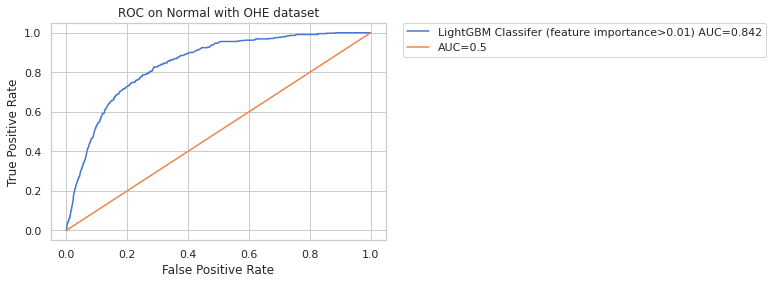

The log loss and auc was found to be 0.135 and 0.842 for LightGBM Classifer (feature importance>0.01) on Normal with OHE dataset.


In [128]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [129]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.3min finished


The best auc score was 0.823
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 1000}
CPU times: user 2min 16s, sys: 738 ms, total: 2min 17s
Wall time: 50min 32s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [130]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [131]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Normal with OHE dataset 		 



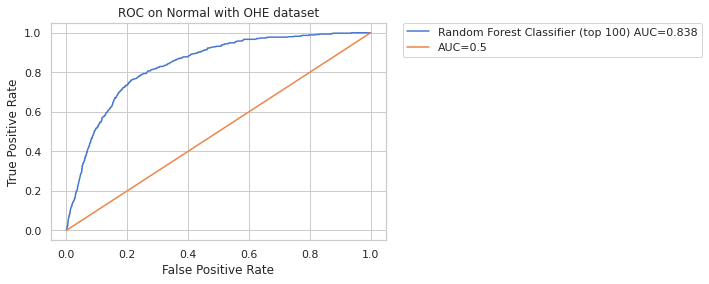

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Normal with OHE dataset.


In [132]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [133]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648


# XGB Classifier (top 100)

In [150]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=894,
                      reg_alpha = 1,
                      max_depth=6, 
                      gamma=0
                     )


In [151]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.815423	validation_0-error:0.039376
[1]	validation_0-auc:0.817628	validation_0-error:0.039551
[2]	validation_0-auc:0.820431	validation_0-error:0.039639
[3]	validation_0-auc:0.822985	validation_0-error:0.039551
[4]	validation_0-auc:0.823683	validation_0-error:0.039551
[5]	validation_0-auc:0.826887	validation_0-error:0.039551
[6]	validation_0-auc:0.828219	validation_0-error:0.039551
[7]	validation_0-auc:0.82723	validation_0-error:0.039551
[8]	validation_0-auc:0.825949	validation_0-error:0.039551
[9]	validation_0-auc:0.824781	validation_0-error:0.039551
[10]	validation_0-auc:0.82304	validation_0-error:0.039551
[11]	validation_0-auc:0.821889	validation_0-error:0.039551
[12]	validation_0-auc:0.821902	validation_0-error:0.039551
[13]	validation_0-auc:0.822632	validation_0-error:0.039551
[14]	validation_0-auc:0.821613	validation_0-error:0.039551
[15]	validation_0-auc:0.821676	validation_0-error:0.039551
[16]	validation_0-auc:0.821052	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=894, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Normal with OHE dataset 		 



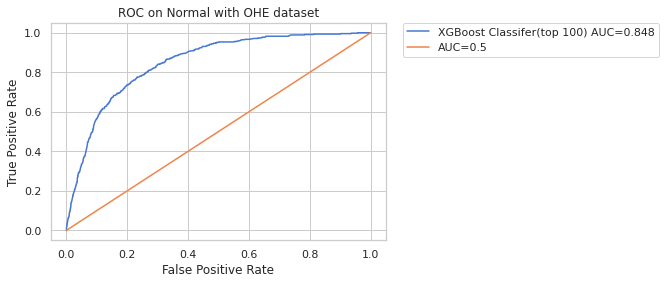

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer(top 100) on Normal with OHE dataset.


In [152]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [153]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132606,0.848107


# LightGBM Classifier (top 100)

In [172]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.9,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0,
                     )
#valid_0's auc: 0.849271

In [173]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165877	valid_0's auc: 0.802061
[2]	valid_0's binary_logloss: 0.165238	valid_0's auc: 0.808036
[3]	valid_0's binary_logloss: 0.164621	valid_0's auc: 0.812425
[4]	valid_0's binary_logloss: 0.163917	valid_0's auc: 0.824921
[5]	valid_0's binary_logloss: 0.163282	valid_0's auc: 0.828883
[6]	valid_0's binary_logloss: 0.162709	valid_0's auc: 0.830197
[7]	valid_0's binary_logloss: 0.16212	valid_0's auc: 0.83204
[8]	valid_0's binary_logloss: 0.1616	valid_0's auc: 0.831416
[9]	valid_0's binary_logloss: 0.161108	valid_0's auc: 0.829501
[10]	valid_0's binary_logloss: 0.160676	valid_0's auc: 0.828519
[11]	valid_0's binary_logloss: 0.160253	valid_0's auc: 0.82715
[12]	valid_0's binary_logloss: 0.159799	valid_0's auc: 0.826582
[13]	valid_0's binary_logloss: 0.159302	valid_0's auc: 0.828189
[14]	valid_0's binary_logloss: 0.158908	valid_0's auc: 0.827294
[15]	valid_0's binary_logloss: 0.158503	valid_0's auc: 0.827989
[16]	valid_0's binary_logloss: 0.158054	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=6, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=947, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Normal with OHE dataset 		 



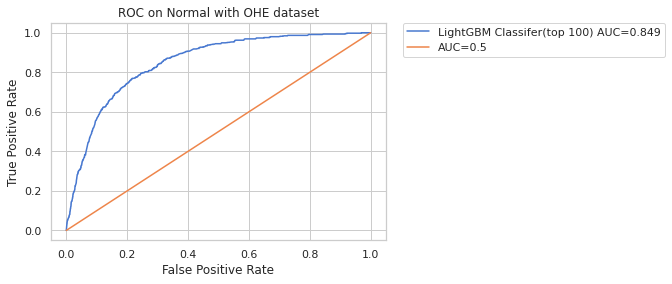

The log loss and auc was found to be 0.132 and 0.849 for LightGBM Classifer(top 100) on Normal with OHE dataset.


In [174]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [175]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132606,0.848107


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 48.2min finished


The best auc score was 0.820
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 57s, sys: 561 ms, total: 2min 57s
Wall time: 51min 10s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [176]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [177]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Normal with OHE dataset 		 



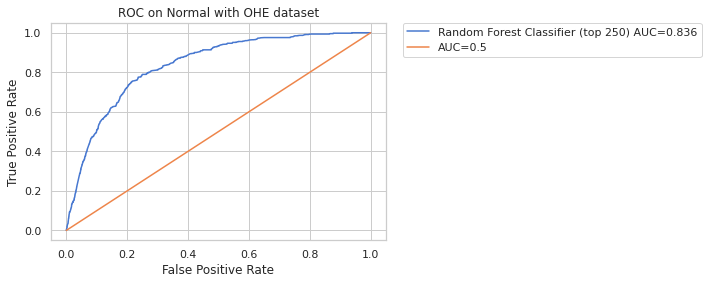

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (top 250) on Normal with OHE dataset.


In [178]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [179]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132606,0.848107


# XGB Classifier (top 250)

In [208]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.6, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=710,
                      reg_alpha = 0.3,
                      max_depth=6, 
                      gamma=0
                     )

In [209]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.77088	validation_0-error:0.040165
[1]	validation_0-auc:0.786779	validation_0-error:0.039989
[2]	validation_0-auc:0.812626	validation_0-error:0.039551
[3]	validation_0-auc:0.816363	validation_0-error:0.039639
[4]	validation_0-auc:0.82183	validation_0-error:0.039551
[5]	validation_0-auc:0.820711	validation_0-error:0.039551
[6]	validation_0-auc:0.823499	validation_0-error:0.039551
[7]	validation_0-auc:0.823668	validation_0-error:0.039551
[8]	validation_0-auc:0.824155	validation_0-error:0.039551
[9]	validation_0-auc:0.824532	validation_0-error:0.039551
[10]	validation_0-auc:0.825521	validation_0-error:0.039551
[11]	validation_0-auc:0.826191	validation_0-error:0.039551
[12]	validation_0-auc:0.827161	validation_0-error:0.039551
[13]	validation_0-auc:0.82771	validation_0-error:0.039551
[14]	validation_0-auc:0.827427	validation_0-error:0.039551
[15]	validation_0-auc:0.827296	validation_0-error:0.039551
[16]	validation_0-auc:0.826293	validation_0-error:0.039551
[17]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=710, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Normal with OHE dataset 		 



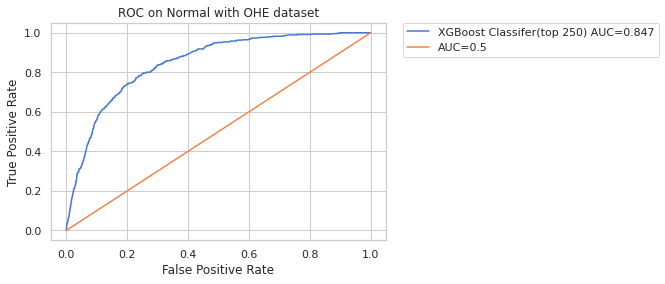

The log loss and auc was found to be 0.133 and 0.847 for XGBoost Classifer(top 250) on Normal with OHE dataset.


In [210]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [211]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Normal with OHE,0.518678,0.824807
1,Decision Tree Classifier,Normal with OHE,0.148823,0.773022
2,Random Forest Classifier,Normal with OHE,0.137266,0.833413
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
5,Random Forest Classifier (feature importance>0...,Normal with OHE,0.136814,0.835257
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
9,XGBoost Classifer(top 100),Normal with OHE,0.132606,0.848107


# LightGBM Classifier (top 250)

In [228]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=7,
                      gamma=0
                     )


In [229]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165871	valid_0's auc: 0.804614
[2]	valid_0's binary_logloss: 0.165102	valid_0's auc: 0.827785
[3]	valid_0's binary_logloss: 0.164446	valid_0's auc: 0.829242
[4]	valid_0's binary_logloss: 0.163802	valid_0's auc: 0.833261
[5]	valid_0's binary_logloss: 0.163258	valid_0's auc: 0.83218
[6]	valid_0's binary_logloss: 0.16271	valid_0's auc: 0.831267
[7]	valid_0's binary_logloss: 0.16214	valid_0's auc: 0.832551
[8]	valid_0's binary_logloss: 0.161571	valid_0's auc: 0.834241
[9]	valid_0's binary_logloss: 0.161009	valid_0's auc: 0.83415
[10]	valid_0's binary_logloss: 0.160483	valid_0's auc: 0.833943
[11]	valid_0's binary_logloss: 0.159967	valid_0's auc: 0.834168
[12]	valid_0's binary_logloss: 0.159467	valid_0's auc: 0.834131
[13]	valid_0's binary_logloss: 0.158925	valid_0's auc: 0.835313
[14]	valid_0's binary_logloss: 0.158463	valid_0's auc: 0.835727
[15]	valid_0's binary_logloss: 0.158	valid_0's auc: 0.835806
[16]	valid_0's binary_logloss: 0.157512	valid_0's auc: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               gamma=0, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=447, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=1, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Normal with OHE dataset 		 



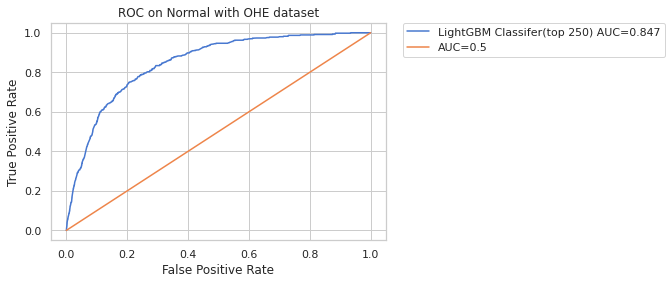

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Normal with OHE dataset.


In [230]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

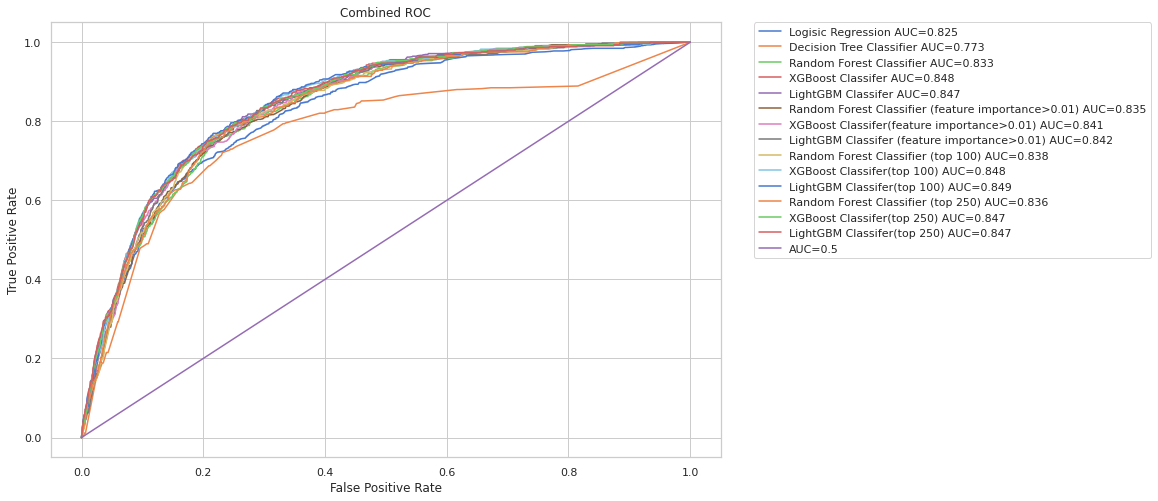

In [231]:
plot_auc(y_val,y_preds,labels)

In [234]:
result_df.sort_values(by='auc',ascending=False)

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Normal with OHE,0.132215,0.849271
9,XGBoost Classifer(top 100),Normal with OHE,0.132606,0.848107
3,XGBoost Classifer,Normal with OHE,0.132678,0.847850
12,XGBoost Classifer(top 250),Normal with OHE,0.132926,0.847323
4,LightGBM Classifer,Normal with OHE,0.133250,0.847251
13,LightGBM Classifer(top 250),Normal with OHE,0.133069,0.846977
7,LightGBM Classifer (feature importance>0.01),Normal with OHE,0.134551,0.841908
6,XGBoost Classifer(feature importance>0.01),Normal with OHE,0.134773,0.840753
8,Random Forest Classifier (top 100),Normal with OHE,0.136083,0.837648
11,Random Forest Classifier (top 250),Normal with OHE,0.136698,0.835555
